<font color="#CC3D3D"><p>
# Build models (ver.1027)

- `INPUT`: 학습용(`X_train.csv`, `y_train`)과 평가용(`X_test.csv`) 데이터 
- `OUTPUT`: 위 데이터를 이용하여 구축한 모형이 생성한 예측결과(`submission.csv`)

##### Imports

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

### 1. Read Data

In [3]:
# 학습용과 평가용(제출용) 데이터를 읽어들인다.
train = pd.read_csv('X_traintest.csv', encoding='cp949')
test = pd.read_csv('X_testtest.csv', encoding='cp949')

# 분석에 필요없는 ID 필드를 데이터에서 제거하고, 전처리 후 학습용과 제출용 데이터를 분리하기 위해 ID는 보관한다.
train_id = train['cust_id']
test_id = test['cust_id']
del train['cust_id'], test['cust_id']

# 학습용 정답 데이터를 읽는다.
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

# 전처리를 동일하게 적용하기 위해 두 데이터를 합한다.
features = pd.concat([train, test]).reset_index(drop=True)
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,내점일수,구매주기,봄-구매비율,여름-구매비율,가을-구매비율,...,준보석/시계,차/커피,축산가공,침구/수예,캐주얼,커리어,통신/컴퓨터,트래디셔널,피혁잡화,화장품
0,68282840,74,922741,11264000,35,19,17,0.094595,0.391892,0.378378,...,0,0,2,0,0,0,0,0,0,7
1,2136000,3,712000,2136000,2,2,1,0.000000,0.000000,1.000000,...,0,0,0,0,0,0,0,1,0,0
2,3197000,4,799250,1639000,1,2,1,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,16077620,44,365400,4935000,24,18,16,0.590909,0.159091,0.113636,...,0,2,1,1,1,0,0,0,0,0
4,29050000,3,9683333,24000000,2,2,85,0.333333,0.000000,0.666667,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,82581500,14,5898679,23976000,8,8,40,0.071429,0.285714,0.285714,...,0,0,0,0,0,0,0,1,1,0
5978,480000,1,480000,480000,1,1,0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
5979,260003790,71,3662025,25750000,38,19,18,0.154930,0.225352,0.154930,...,0,0,0,1,4,1,0,7,2,0
5980,88991520,18,4943973,18120000,9,5,60,0.277778,0.166667,0.277778,...,0,0,0,1,0,0,0,0,0,0


### 2. EDA

In [4]:
#matplotlib 한글깨짐 지원

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)  

GridSpec(6, 6)

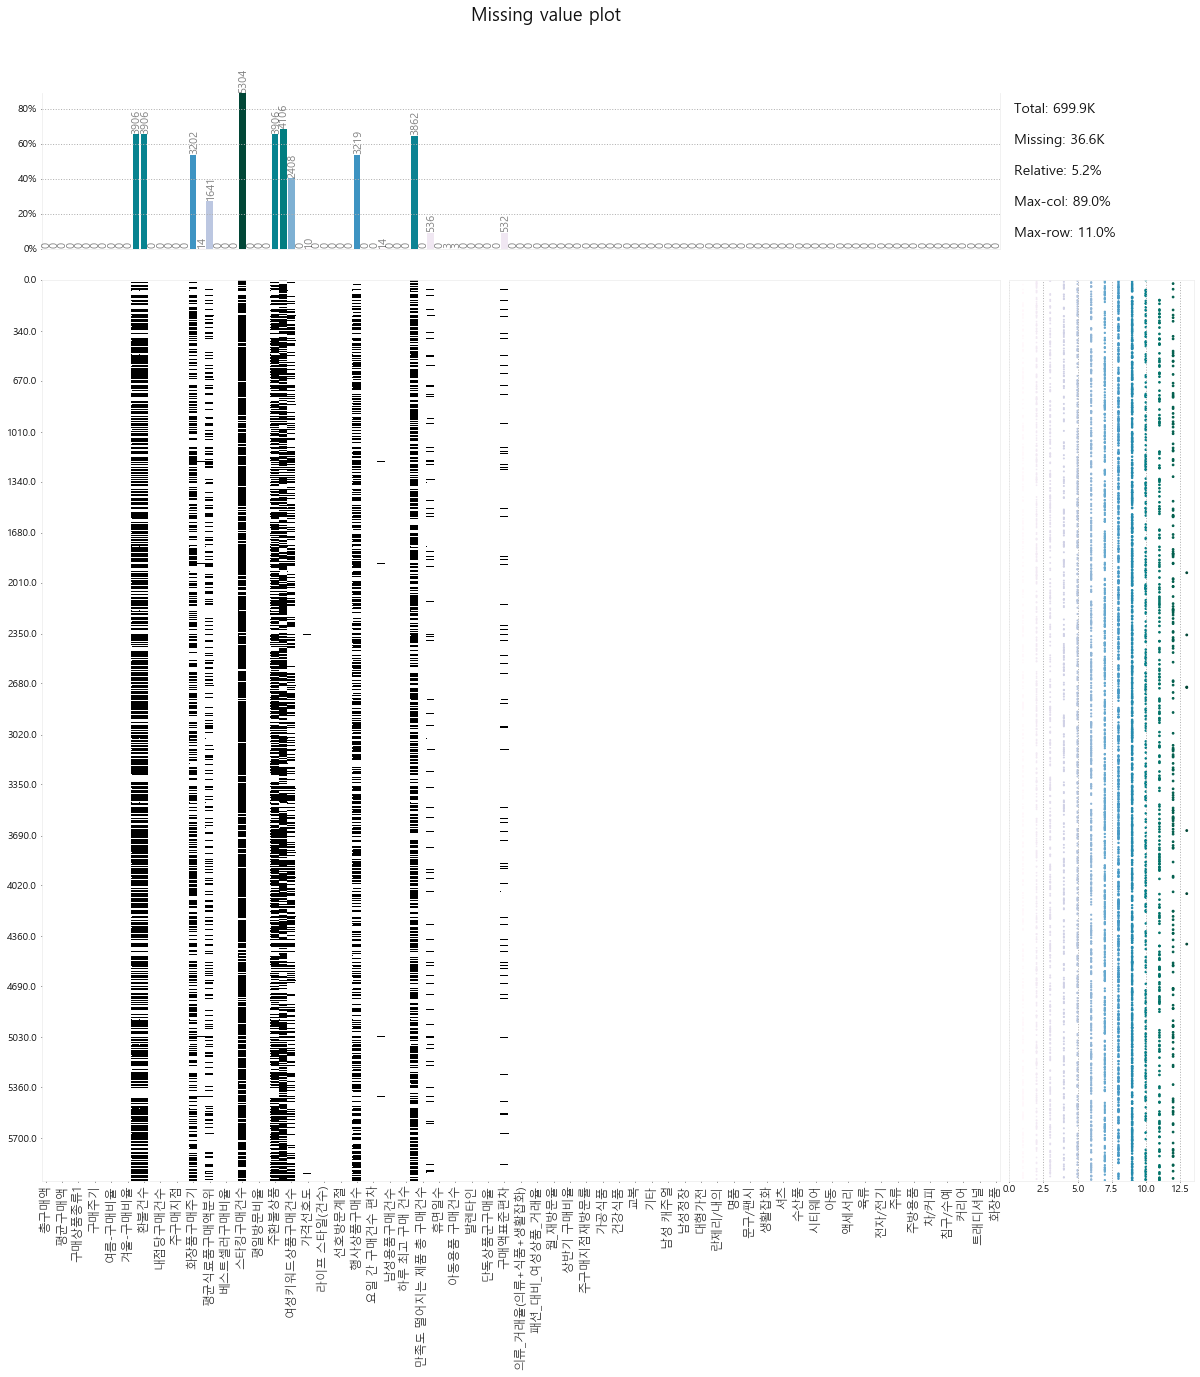

In [5]:
# 결측값 파악

klib.missingval_plot(features)

Note: The number of non binary numerical features is very large (105), please consider splitting the data. Showing plots for the first 20 numerical features. Override this by setting showall=True.
Dropped 3906 missing values from column 환불금액.
Dropped 3906 missing values from column 환불건수.
Dropped 3202 missing values from column 화장품구매주기.
Dropped 14 missing values from column 식료품구매액비율.
Dropped 1641 missing values from column 평균식료품구매액분위.


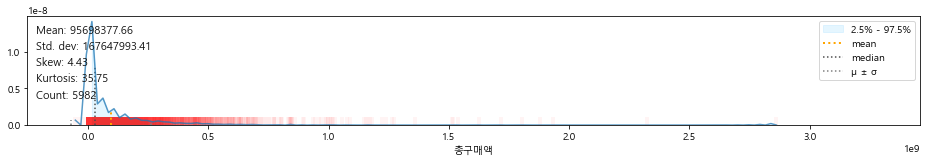

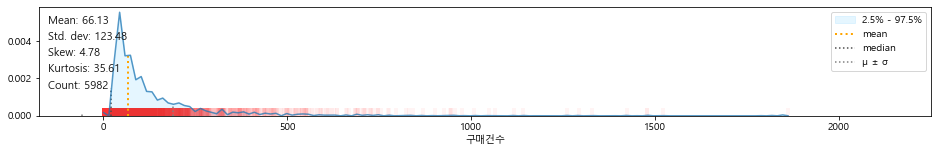

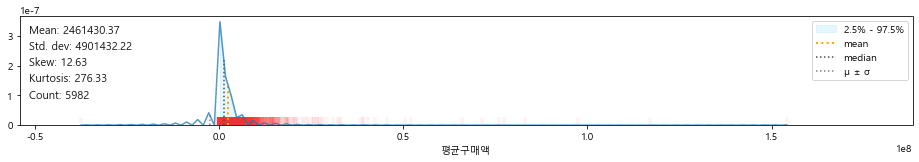

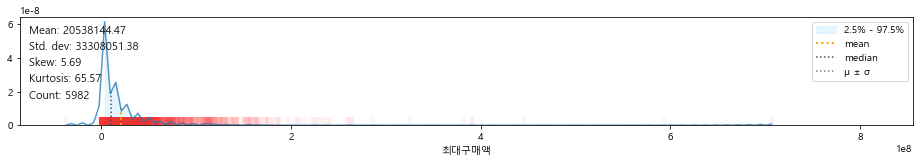

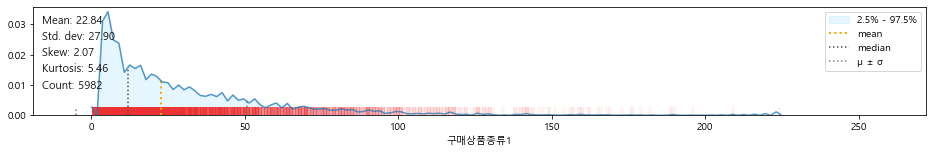

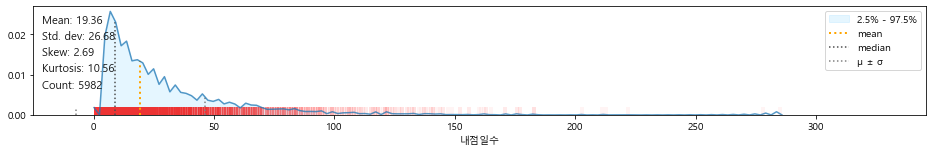

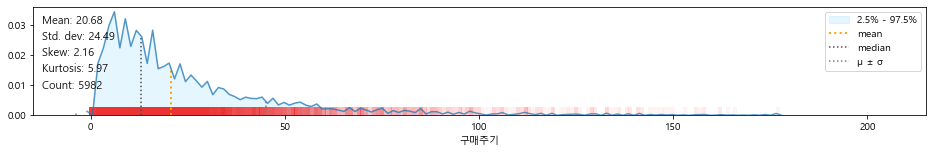

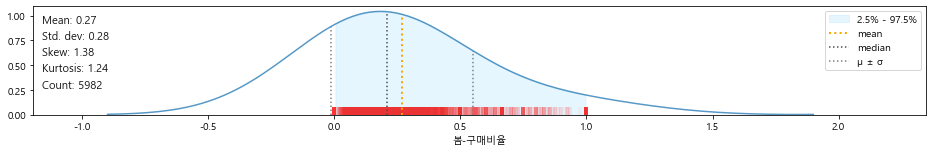

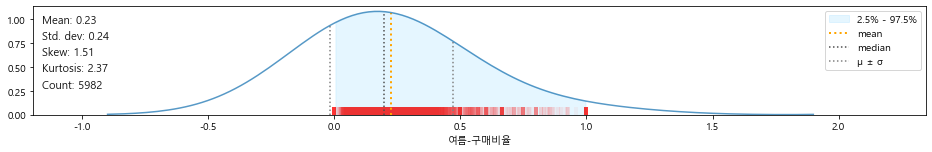

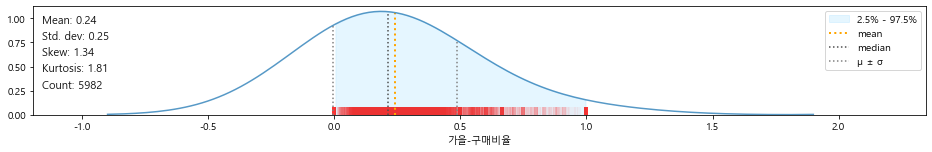

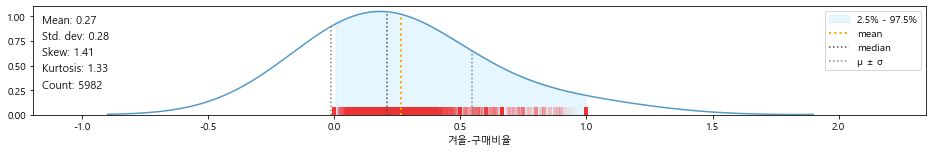

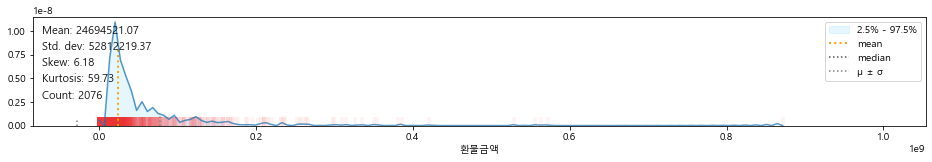

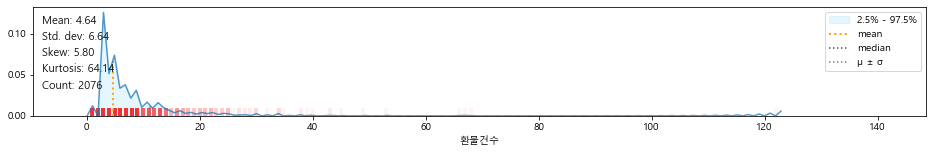

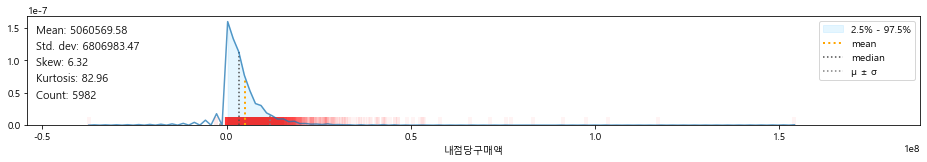

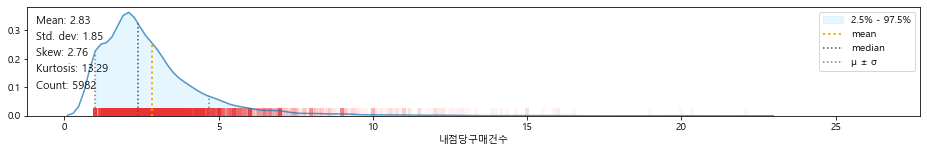

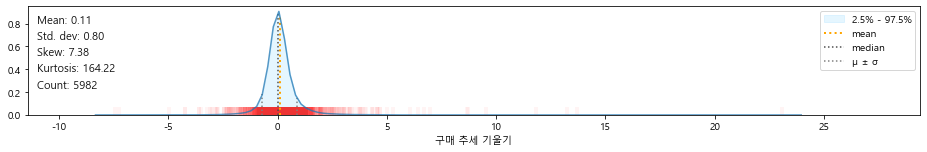

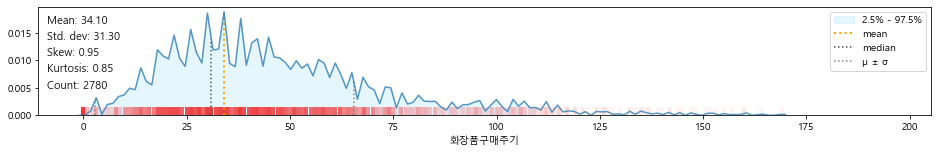

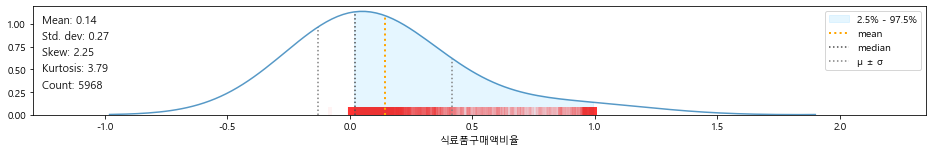

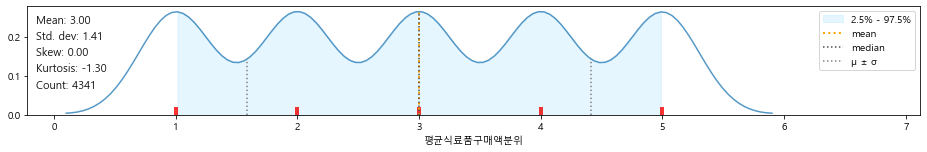

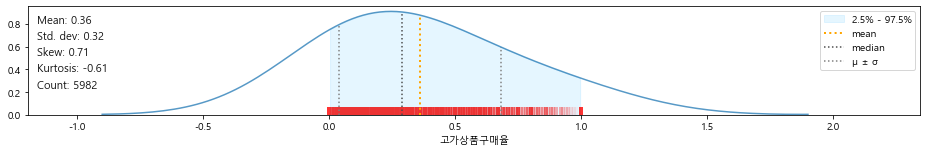

In [6]:
# 수치형 속성 파악

klib.dist_plot(features)

GridSpec(6, 8)

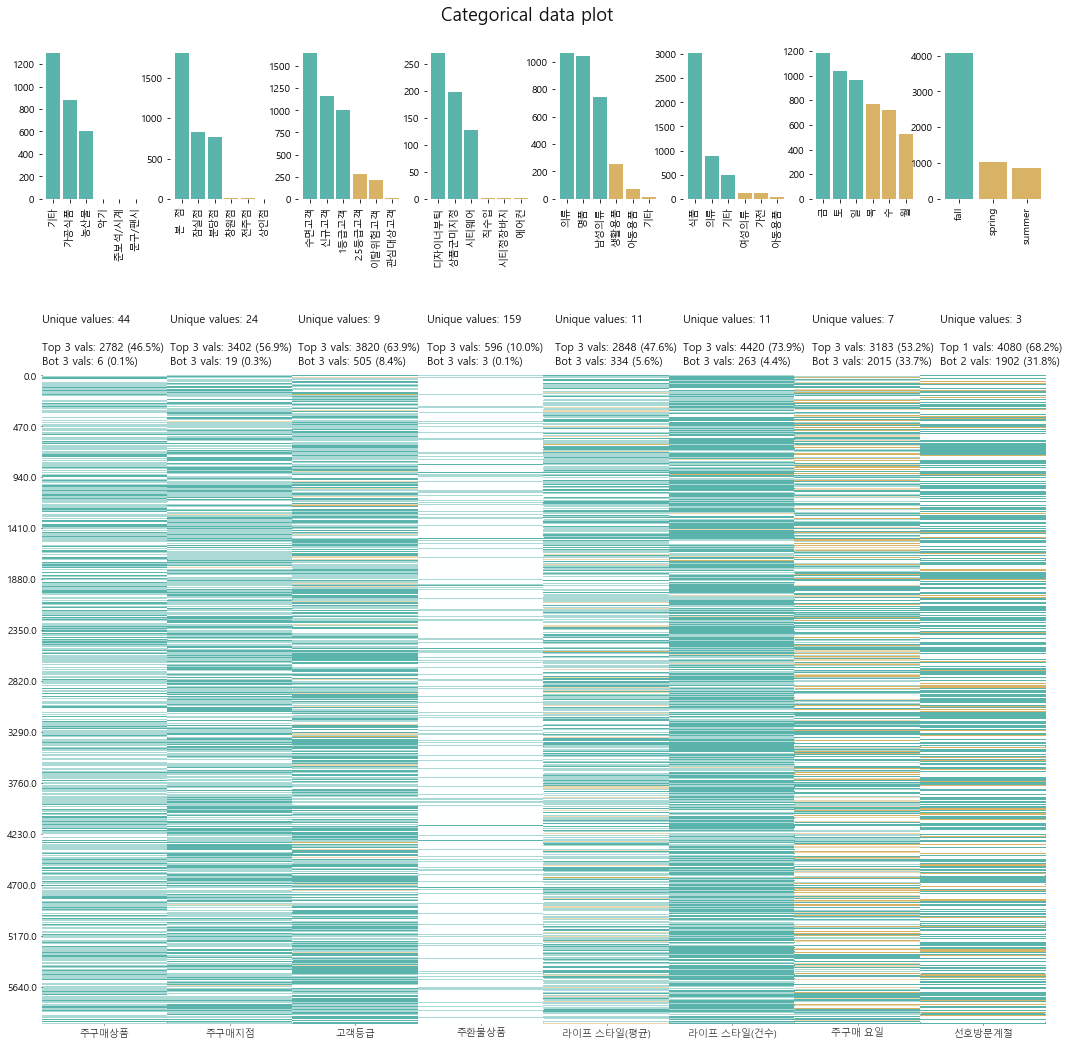

In [7]:
# 범주형 속성 파악

klib.cat_plot(features)

Displaying absolute correlations above the threshold (0.3). Specify a positive "threshold" to further limit the results.


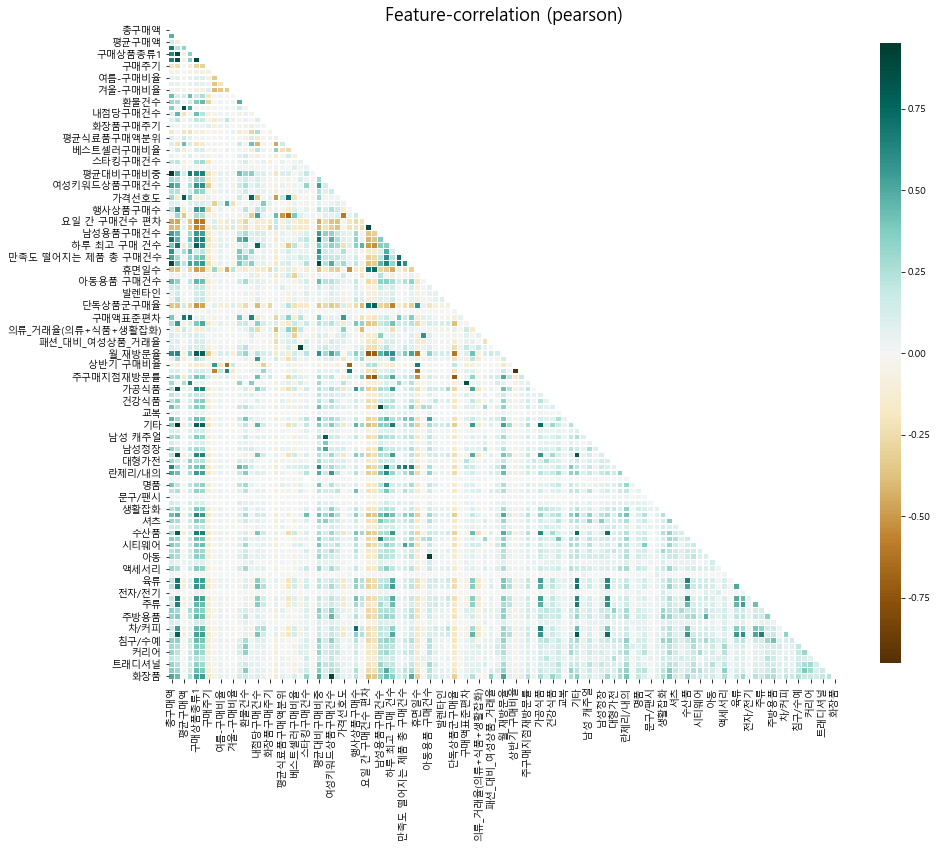

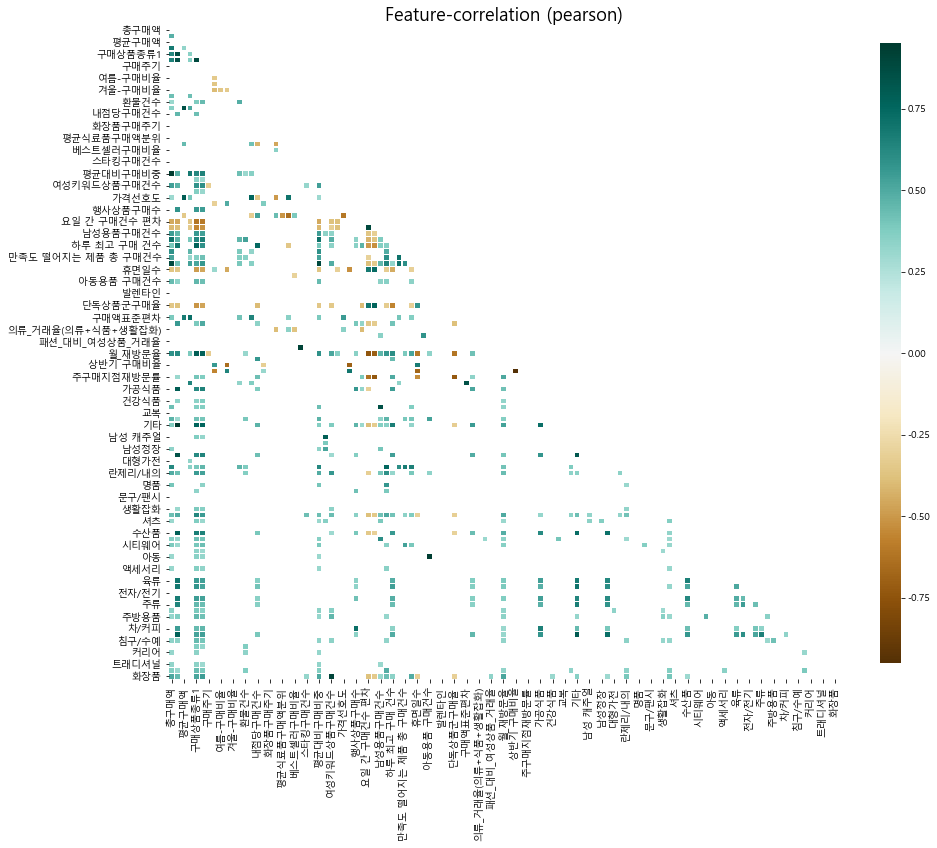

In [8]:
# 속성간 유사성 파악

klib.corr_plot(features, annot=False, figsize=(15,12))
klib.corr_plot(features, split='high', annot=False, figsize=(15,12))

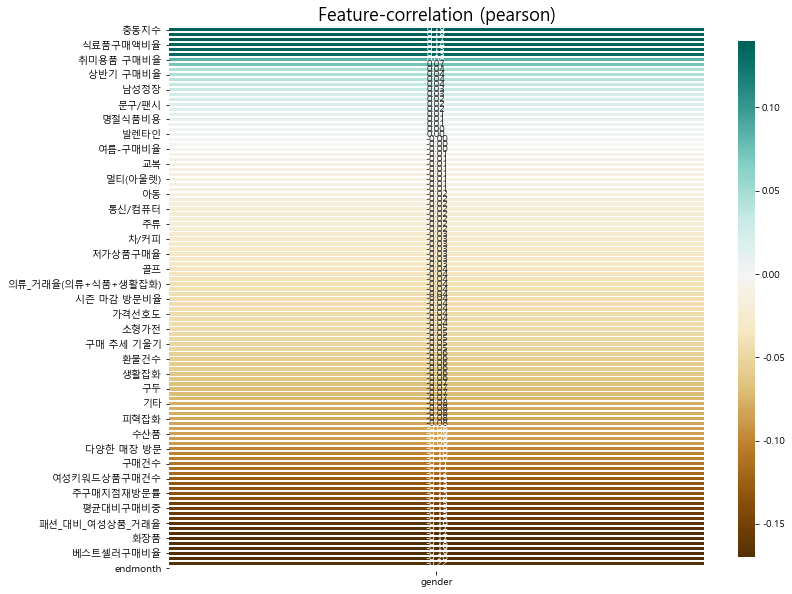

In [9]:
# 속성별 예측 능력 파악 

klib.corr_plot(pd.concat([train, y_train], axis=1), target='gender')

### 3. Data Cleansing & Feature Engineering

In [10]:
# 범주형 변수와 수치형 변수를 분리
cat_features = features.select_dtypes(include=['object']).columns.to_list()
num_features = features.select_dtypes(exclude='object').columns.to_list()
#num_features = [c for c in features.columns.tolist() if c not in cat_features]  

*Impute Missing Values*

In [11]:
# 결측값 처리
features[num_features] = features[num_features].fillna(0)
features[cat_features] = SimpleImputer(strategy="most_frequent").fit_transform(features[cat_features])
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,내점일수,구매주기,봄-구매비율,여름-구매비율,가을-구매비율,...,준보석/시계,차/커피,축산가공,침구/수예,캐주얼,커리어,통신/컴퓨터,트래디셔널,피혁잡화,화장품
0,68282840,74,922741,11264000,35,19,17,0.094595,0.391892,0.378378,...,0,0,2,0,0,0,0,0,0,7
1,2136000,3,712000,2136000,2,2,1,0.000000,0.000000,1.000000,...,0,0,0,0,0,0,0,1,0,0
2,3197000,4,799250,1639000,1,2,1,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,16077620,44,365400,4935000,24,18,16,0.590909,0.159091,0.113636,...,0,2,1,1,1,0,0,0,0,0
4,29050000,3,9683333,24000000,2,2,85,0.333333,0.000000,0.666667,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,82581500,14,5898679,23976000,8,8,40,0.071429,0.285714,0.285714,...,0,0,0,0,0,0,0,1,1,0
5978,480000,1,480000,480000,1,1,0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
5979,260003790,71,3662025,25750000,38,19,18,0.154930,0.225352,0.154930,...,0,0,0,1,4,1,0,7,2,0
5980,88991520,18,4943973,18120000,9,5,60,0.277778,0.166667,0.277778,...,0,0,0,1,0,0,0,0,0,0


*Deal with Outliers*

In [12]:
# 수치형 변수에 대해 이상치(outlier)를 처리
features[num_features] = features[num_features].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

*Transform Features*

In [13]:
# 수치형 변수를 정규분포에 가깝게 만들기
features[num_features] = PowerTransformer(standardize=True).fit_transform(features[num_features])
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,내점일수,구매주기,봄-구매비율,여름-구매비율,가을-구매비율,...,준보석/시계,차/커피,축산가공,침구/수예,캐주얼,커리어,통신/컴퓨터,트래디셔널,피혁잡화,화장품
0,0.500815,0.829928,-0.252553,0.129557,0.914315,0.634090,0.287488,-0.574876,0.980639,0.847424,...,0.0,-0.708906,1.313470,-0.469897,-0.547992,-0.371073,0.0,-0.442072,-0.526342,1.421571
1,-1.122743,-1.112149,-0.448631,-0.887585,-1.153986,-0.993810,-1.210683,-1.310247,-1.213870,1.878999,...,0.0,-0.708906,-0.690264,-0.469897,-0.547992,-0.371073,0.0,2.238380,-0.526342,-0.881499
2,-0.966821,-0.963162,-0.362351,-1.021675,-1.484483,-0.993810,-1.210683,-1.310247,-1.213870,-1.240890,...,0.0,-0.708906,-0.690264,-0.469897,-0.547992,-0.371073,0.0,-0.442072,-0.526342,-0.881499
3,-0.260227,0.493805,-0.912608,-0.415818,0.606138,0.593285,0.237687,1.277301,-0.048308,-0.412197,...,0.0,1.349396,0.903949,2.110843,1.620043,-0.371073,0.0,-0.442072,-0.526342,-0.881499
4,0.035095,-1.112149,1.799611,0.711345,-1.153986,-0.993810,1.730289,0.592909,-1.213870,1.646385,...,0.0,-0.708906,-0.690264,-0.469897,-0.547992,-0.371073,0.0,-0.442072,-0.526342,0.323351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,0.611129,-0.232402,1.455805,0.710519,-0.248711,-0.020766,1.085903,-0.735616,0.581798,0.484796,...,0.0,-0.708906,-0.690264,-0.469897,-0.547992,-0.371073,0.0,2.238380,1.867615,-0.881499
5978,-1.638093,-1.576152,-0.729648,-1.561587,-1.484483,-1.375368,-1.541375,-1.310247,-1.213870,-1.240890,...,0.0,-0.708906,-0.690264,-0.469897,-0.547992,-0.371073,0.0,-0.442072,-0.526342,-0.881499
5979,1.333155,0.803103,0.960379,0.769898,0.982181,0.634090,0.335229,-0.204247,0.306280,-0.164068,...,0.0,-0.708906,-0.690264,2.110843,1.925223,2.692669,0.0,2.283921,1.939811,-0.881499
5980,0.655202,-0.075760,1.267288,0.485272,-0.161135,-0.369851,1.531439,0.383025,-0.004617,0.450433,...,0.0,-0.708906,-0.690264,2.110843,-0.547992,-0.371073,0.0,-0.442072,-0.526342,-0.881499


*Encode Categorical Variables*

In [14]:
# 범주형 변수에 One-Hot-Encoding 후 수치형 변수와 병합
if len(cat_features) > 0:
    features = pd.concat([features[num_features], pd.get_dummies(features[cat_features])], axis=1)
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,내점일수,구매주기,봄-구매비율,여름-구매비율,가을-구매비율,...,주구매 요일_금,주구매 요일_목,주구매 요일_수,주구매 요일_월,주구매 요일_일,주구매 요일_토,주구매 요일_화,선호방문계절_fall,선호방문계절_spring,선호방문계절_summer
0,0.500815,0.829928,-0.252553,0.129557,0.914315,0.634090,0.287488,-0.574876,0.980639,0.847424,...,0,0,0,0,0,1,0,1,0,0
1,-1.122743,-1.112149,-0.448631,-0.887585,-1.153986,-0.993810,-1.210683,-1.310247,-1.213870,1.878999,...,0,1,0,0,0,0,0,1,0,0
2,-0.966821,-0.963162,-0.362351,-1.021675,-1.484483,-0.993810,-1.210683,-1.310247,-1.213870,-1.240890,...,0,0,0,1,0,0,0,1,0,0
3,-0.260227,0.493805,-0.912608,-0.415818,0.606138,0.593285,0.237687,1.277301,-0.048308,-0.412197,...,0,0,0,0,0,0,1,0,1,0
4,0.035095,-1.112149,1.799611,0.711345,-1.153986,-0.993810,1.730289,0.592909,-1.213870,1.646385,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,0.611129,-0.232402,1.455805,0.710519,-0.248711,-0.020766,1.085903,-0.735616,0.581798,0.484796,...,0,0,0,0,0,1,0,1,0,0
5978,-1.638093,-1.576152,-0.729648,-1.561587,-1.484483,-1.375368,-1.541375,-1.310247,-1.213870,-1.240890,...,0,0,0,1,0,0,0,1,0,0
5979,1.333155,0.803103,0.960379,0.769898,0.982181,0.634090,0.335229,-0.204247,0.306280,-0.164068,...,0,0,0,0,1,0,0,1,0,0
5980,0.655202,-0.075760,1.267288,0.485272,-0.161135,-0.369851,1.531439,0.383025,-0.004617,0.450433,...,0,0,0,0,0,1,0,1,0,0


*Select Features*

In [15]:
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=5) # 교차검증 시 남녀비율을 맞추기 위해 사용

100%|██████████| 95/95 [00:59<00:00,  1.61it/s]

(43, 0.7573679592163802)


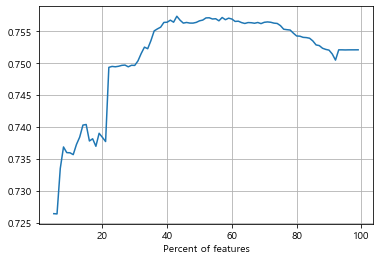

In [16]:
# 학습용과 test 데이터로 분리
features = pd.concat([pd.concat([train_id, test_id]).reset_index(drop=True), features], axis=1)
X_train = features.query('cust_id in @train_id').drop('cust_id', axis=1)
X_test = features.query('cust_id in @test_id').drop('cust_id', axis=1)

# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LogisticRegression(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X_train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=skfold).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [17]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

print(X_train.shape)
print(features.iloc[:,1:].columns[fs.get_support()].tolist())

(3500, 162)
['총구매액', '구매건수', '평균구매액', '최대구매액', '구매상품종류1', '내점일수', '구매주기', '봄-구매비율', '여름-구매비율', '가을-구매비율', '겨울-구매비율', '환불금액', '환불건수', '내점당구매액', '내점당구매건수', '구매 추세 기울기', '화장품구매주기', '식료품구매액비율', '평균식료품구매액분위', '고가상품구매율', '베스트셀러구매비율', '환불비율', '스타킹구매건수', '평일방문비율', '평균대비구매비중', '남성포함상품구매건수', '여성키워드상품구매건수', '다양한 매장 방문', '가격선호도', '선호방문월', '행사상품구매수', '저가상품구매율', '요일 간 구매건수 편차', '충동지수', '남성용품구매건수', '여성용품구매건수', '하루 최고 구매 건수', '만족도 떨어지는 제품 총 구입금액', '만족도 떨어지는 제품 총 구매건수', '가성비 제품 총 구입금액', '휴면일수', '아동용품 구매건수', '명절식품비용', '단독상품군구매율', '구매액표준편차', '중복구매배수', '의류_거래율(의류+식품+생활잡화)', '패션_대비_남성상품_거래율', '패션_대비_여성상품_거래율', '전체방문_중_환불방문(표준화)', '월_재방문율', '시즌 마감 방문비율', '상반기 구매비율', '구매 추세', '주구매지점재방문률', '내점시마다 구매액의 일관성', '가공식품', '건강식품', '골프', '구두', '기타', '남성 캐주얼', '남성정장', '농산물', '디자이너', '란제리/내의', '명품', '모피/피혁', '생활잡화', '섬유잡화', '셔츠', '수산품', '스포츠', '시티웨어', '식기', '아동', '액세서리', '육류', '일용잡화', '젓갈/반찬', '주류', '주방가전', '주방용품', '차/커피', '축산가공', '침구/수예', '캐주얼', '커리어', '피혁잡화', '화장품', '주구매상품_가공식품', '주구매상품_건강식품', '주구매상품_골프', '주구매상품_구두', 

In [1]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### 4. Model Tuning (Hyperparameter Optimization)

In [19]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
# stratify=y_train 를 통해 데이터를 분할할 때 층화추출을 실시(불균형을 해소한다.)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=0)

In [ ]:
# 각 모델의 최적 파라미터를 찾기위해 랜덤서치를 사용
# 범위를 좁혀나가며 최적의 파라미터를 찾음

In [3]:
clfs = [
    (
        KNeighborsClassifier(),              # 사용하려는 모델
        {'n_neighbors': [3,5,7,9,11,13,15,17,19],# 최적화하려는 하이퍼파라미터
         'weights': ['uniform','distance']}   # 스페이스를 좁게 했다. 그래서 넓게 해서 찾아보도록 하자.
    ),
    (
         MLPClassifier(random_state=0),
        {'batch_size': [32, 64, 128],
         'learning_rate' : ['constant', 'adaptive', 'invscaling'],
         'activation': ['tanh', 'relu', 'logistic'],
         'solver': ['sgd', 'adam'],
         'alpha': [1e-07,1e-06,0.0001,0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,0.9],
         'hidden_layer_sizes': [(32,),(64,),(128,),(32,16),(64,32,16)]}
    ),
    (
        LogisticRegression(random_state=0),  
        {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],      
         'penalty': ['l1', 'l2'],}
    ),
    (AdaBoostClassifier(),
     {'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1,1,10,100]}
    ),
    (
        RandomForestClassifier(random_state=0),
        {'n_estimators': [372],
         'max_depth': [7]}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        GradientBoostingClassifier(random_state=0),
        {'n_estimators': [258],
         'learning_rate': [0.03],
         'max_depth': [3]}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        XGBClassifier(random_state=0),
        {'n_estimators': [126],
         'learning_rate': [0.04],
         'max_depth': [3]}
    ),
    (
        ExtraTreesClassifier(random_state=0),
       {'n_estimators': [370],
         'max_depth': [9]}
    ),
    (
        LGBMClassifier(random_state=0),
        {'n_estimators': [355],
         'learning_rate': [0.01],
         'max_depth': [3],}
    ),
    (
        LinearDiscriminantAnalysis(),
        {'tol': np.logspace(0,-5,5),
         'solver': ['svd','lsqr','eigen'],
        })]


clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=20, scoring='roc_auc', 
                                     cv=skfold, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_dev, y_dev)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    clfs_tuned.append((clf_name, rand_search, clf_score))

NameError: name 'KNeighborsClassifier' is not defined

### 5. Model Ensemble

*Correlation between models*

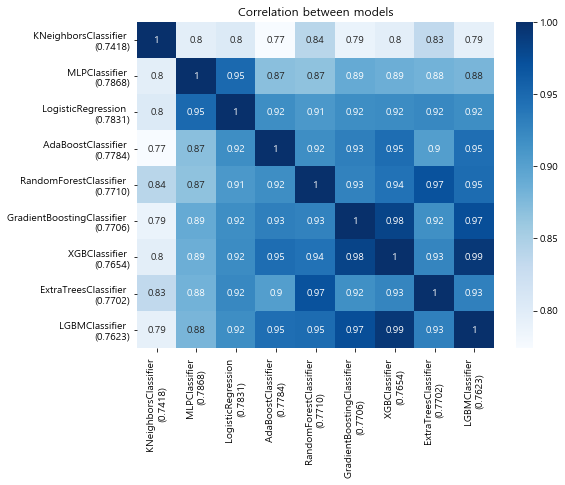

In [21]:
pred_results = []
for name, clf, clf_score in clfs_tuned:
    pred = clf.predict_proba(X_dev)[:,1]
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

*Mean agreement vs. Performance*

In [22]:
# Mean agreement
(ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

KNeighborsClassifier \n(0.7418)          0.803789
MLPClassifier \n(0.7868)                 0.878077
LogisticRegression \n(0.7831)            0.907769
AdaBoostClassifier \n(0.7784)            0.901024
RandomForestClassifier \n(0.7710)        0.915390
GradientBoostingClassifier \n(0.7706)    0.916459
XGBClassifier \n(0.7654)                 0.924267
ExtraTreesClassifier \n(0.7702)          0.911197
LGBMClassifier \n(0.7623)                0.922718
dtype: float64

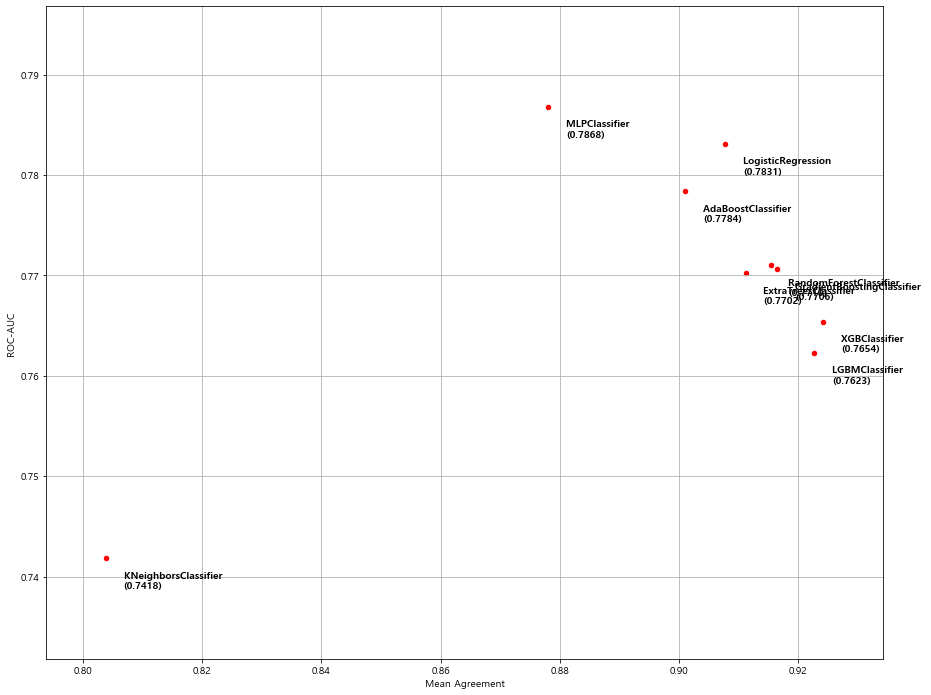

In [23]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(15,12))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

*Averaging Ensemble*

In [24]:
# Averaging 앙상블에 사용하지 않을 모델은 주석 처리하시오.
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression',
    'AdaBoostClassifier'
    'RandomForestClassifier', 
    'GradientBoostingClassifier',
    'XGBClassifier',
    'ExtraTreesClassifier',
    'LGBMClassifier'
]
models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [25]:
max_score = 0
for p in tqdm([0, 1, 2.56]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)    
    for i in range(2, len(models_for_ensemble)+1): # 2개 이상의 모델이 앙상블된 것들 중 가장 성능이 좋은 것을 선택
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict_proba(X_dev)[:,1] for name, clf, _ in models], axis=0)
            else:
                preds = [clf.predict_proba(X_dev)[:,1] for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(y_dev, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

100%|██████████| 3/3 [03:20<00:00, 66.79s/it]

p=0
MLPClassifier●LogisticRegression
0.7888221084162721


In [26]:
# sklearn의 다른 classifier와 호환성을 갖기위해 Custom Classifier인 "AveragingClassifier" 생성

class AveragingClassifier(ClassifierMixin):
    def __init__(self, estimators, p):
        self.estimators = estimators
        self.p = p
    
    def fit(self, X, y):
        return None

    def predict(self, X):
        if self.p == 0:
            pred = gmean([clf.predict(X) for name, clf in estimators], axis=0)
        else:
            preds = [clf.predict(X) for name, clf in estimators]
            pred = (np.sum(np.array(preds)**self.p, axis=0) / len(estimators))**(1/self.p)
        return pred
         
    def predict_proba(self, X):
        if self.p == 0:
            prob = gmean([clf.predict_proba(X) for name, clf in estimators], axis=0)
        else:
            probs = [clf.predict_proba(X) for name, clf in estimators]
            prob = (np.sum(np.array(probs)**self.p, axis=0) / len(estimators))**(1/self.p)
        return prob
    
estimators = [(name, clf) for name, clf, _ in models]
avg_clf = AveragingClassifier(estimators, p)
avg_clf.fit(X_train, y_train)    

In [28]:
# 2-layer stacking

# Initialize 1st level estimators
# 사용하지 않을 모델은 주석 처리하세요.

selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression',
#    'AdaBoostClassifier'
    'RandomForestClassifier', 
    'GradientBoostingClassifier',
    'XGBClassifier',
#    'ExtraTreesClassifier',
#    'LGBMClassifier'
]

estimators = [(name, clf) for name, clf, _ in clfs_tuned if name in selected]
stk_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(random_state=0), cv=10)

stk_clf.fit(X_train, y_train)
print(roc_auc_score(y_dev, stk_clf.predict_proba(X_dev)[:,1]))  

0.7860083099816407


### 6. Deployment

In [38]:
# Averaging ensemble을 적용한 submission
pd.DataFrame({'cust_id': test_id, 'gender': avg_clf.predict_proba(X_test)[:,1]}).to_csv('박현수-submit-1.csv', index=False)

# Weight_voting (soft)을 적용한 submission
pd.DataFrame({'cust_id': test_id, 'gender': voting.predict_proba(X_test)[:,1]}).to_csv('박현수-submit-2.csv', index=False)

<font color="#CC3D3D"><p>
# End